# Exploración de conversaciones de U-Cursos

Foro institucional de ingeniería:

- 1,376,786 mensajes
- 96,667 temas (96,421 temas existentes?)
- hay 246 temas que al parecer ya no existen
- 11,341 usuarios
- desde el 2002-03-11 12:16:44 al 2019-08-01 12:44:51
- distribucion de genero en los mensajes: M: 1,214,446, F: 156,381, NA: 29

# Cargar librerías

In [2]:
%load_ext sql
%env DATABASE_URL=mysql+mysqlconnector://root@localhost/ucursos

env: DATABASE_URL=mysql+mysqlconnector://root@localhost/ucursos


In [90]:
from collections import defaultdict, Counter

import numpy as np
import pandas as pd

from tqdm import tqdm_notebook as tqdm

import spacy
import pickle
from datetime import datetime

from unionfind import UnionFind
from typing import List, Set, Tuple

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
plt.rcParams['figure.figsize'] = [15, 5]

import statistics

import networkx as nx
from networkx.drawing.nx_agraph import write_dot, graphviz_layout


from dataclasses import dataclass

### Estructuras

In [111]:
Pair = Tuple[int, int]

@dataclass
class Tema:
    raiz: int
    titulo: str
    mensajes: Set[int]
    conversacion: Set[Pair]
    fecha_creacion: datetime
        
    def __eq__(self, o):
        if not isinstance(o, Tema):
            return NotImplemented
        return self.raiz == o.raiz
    
    def __len__(self):
        return len(self.mensajes)
    
    def __hash__(self):
        return self.raiz
    
    def __str__(self):
        return f"Tema(raiz={self.raiz}, titulo='{self.titulo}', mensajes={len(self.mensajes)}, conversaciones={len(self.conversacion)}, fecha_creacion='{self.fecha_creacion}')"

    def __repr__(self):
        return self.__str__()
    
    
@dataclass
class Mensaje:
    id_: int
    contenido: str
    autor: int
    genero: str
    es_raiz: bool
    fecha_creacion: datetime
    
    def __eq__(self, o):
        if not isinstance(o, Mensaje):
            return NotImplemented
        return self.id_ == o.id_
    
    def __hash__(self):
        return self.id_

In [112]:
def plot_tema(tema):
    """Grafica tema como grafo"""
    ## crea grafo dirigido
    G = nx.DiGraph()
    
    ## agrega nodos y aristas al grafo, con atributos de cada nodo
    for m1_id, m2_id in tema.conversacion:
        m1 = mensajes[m1_id]
        m2 = mensajes[m2_id]
        G.add_node(m1)
        G.add_node(m2)
        G.add_edge(m1, m2)

    node_colors = ['green' if node.genero == 'M' else 'orange' for node in G.nodes]
    plt.rcParams['figure.figsize'] = [10, 10]
    plt.title(f"({tema.raiz}) ''{tema.titulo}'' - {tema.fecha_creacion}")
    pos = graphviz_layout(G, prog='twopi')
    nx.draw(G, pos, node_color=node_colors, with_labels=False, arrows=True, font_weight='bold')

In [113]:
def random_tema(temas):
    return np.random.choice(temas)

### Cargar datos (dataset completo)

In [114]:
%%time

with open('../data/python/temas.obj.pkl', 'rb') as f:
    temas = pickle.load(f)
    
with open('../data/python/mensajes.obj.pkl', 'rb') as f:
    mensajes = pickle.load(f)

CPU times: user 11.1 s, sys: 2.7 s, total: 13.8 s
Wall time: 21.8 s


In [115]:
temas[1835011]

Tema(raiz=1835011, titulo='Vendo Impresora láser, WIFI, a $30.000', mensajes=1, conversaciones=0, fecha_creacion='2015-12-07 13:27:42')

In [116]:
len(temas[1835011])

1

In [117]:
mensajes[1835011]

Mensaje(id_=1835011, contenido='Hola, estoy vendiendo esta impresora http://www.ripley.cl/ripley-chile/multifuncional-samsung-sl-m2020w-xbh-2000354220305p\r\nEsta 100% nueva, en su caja.\r\n\r\nEl precio de referencia en Ripley.cl es de $50.000\r\n\r\nLa entrega es en Beauchef 851\r\nCualquier duda o consulta, este es mi correo febrito@ing.uchile.cl##@@##2078', autor=955, genero='M', es_raiz=True, fecha_creacion=datetime.datetime(2015, 12, 7, 13, 27, 42))

In [96]:
# temas con todas las respuestas

temas_101 = [tema for tema in temas.values() if len(tema) > 100]

### Viz Grafos

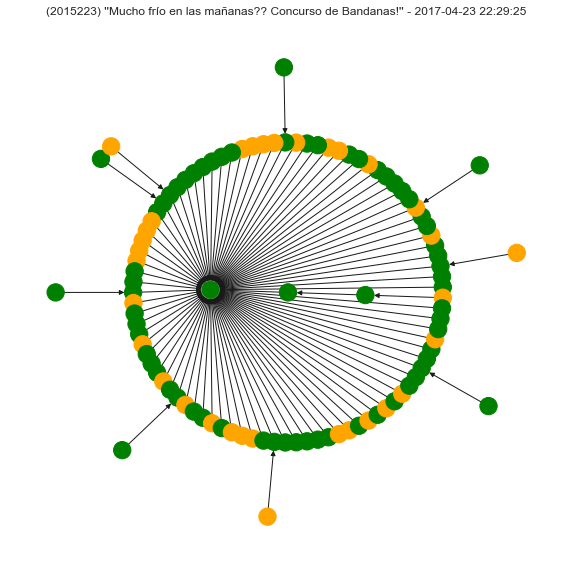

In [105]:
plot_tema(random_tema(temas_101))

# Distribución de género

In [100]:
total_mf = Counter()

for tema in tqdm(temas.values()):
    total_mf.update([m.genero for m in [mensajes[m] for m in tema.mensajes]])       

In [101]:
total_mf

Counter({'M': 1214446, 'F': 156381, '': 29})

In [204]:
tema_genero = dict()

for raiz, tema in tqdm(temas.items()):
    mf = Counter([m.genero for m in [mensajes[m] for m in tema.mensajes]])
    tema_genero[raiz] = mf

In [206]:
records = []
for raiz, counter in tema_genero.items():
    records.append((raiz, counter.get('M', 0), counter.get('F', 0), temas[raiz].fecha_creacion))
    
genero_df = pd.DataFrame.from_records(records, columns=['tema_id', 'M', 'F', 'fecha'])
genero_df['mensajes'] = genero_df['M'] + genero_df['F']
genero_df['frac_M'] = genero_df['M'] / genero_df['mensajes']
genero_df['frac_F'] = genero_df['F'] / genero_df['mensajes']

genero_df.head()

,tema_id,M,F,fecha,mensajes,frac_M,frac_F
0,2204304,6,1,2019-03-15 12:51:56,7,0.857143,0.142857
1,64582,1,0,2008-08-30 00:11:00,1,1.000000,0.000000
2,2203704,3,4,2019-03-14 00:23:19,7,0.428571,0.571429
3,2205306,2,0,2019-03-18 15:33:35,2,1.000000,0.000000
4,359250,32,4,2010-04-14 11:51:09,36,0.888889,0.111111


## Cantidad de mensajes promedio por tema en el tiempo

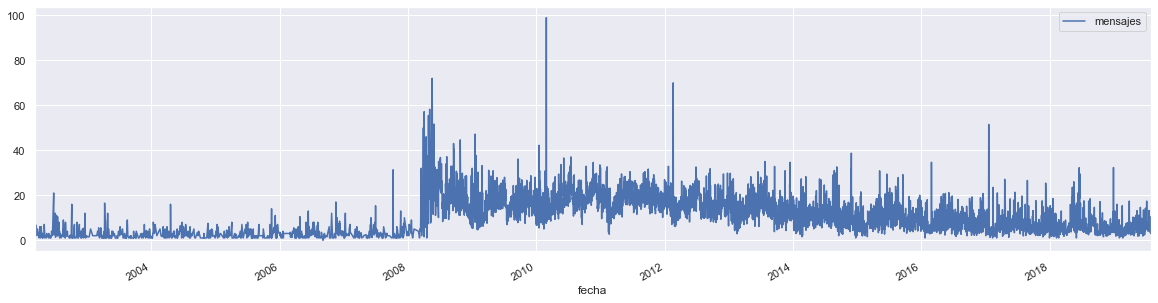

In [213]:
## por dia

msg_df = genero_df[['fecha', 'mensajes']].set_index('fecha').groupby(pd.Grouper(freq='D')).mean()
msg_df = msg_df.dropna()
msg_df.reset_index().plot.line(x='fecha', y='mensajes')

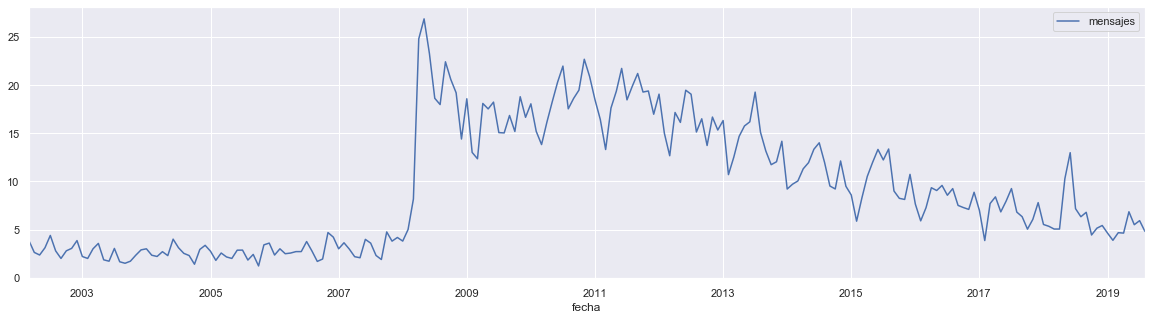

In [214]:
## por mes

msg_df = genero_df[['fecha', 'mensajes']].set_index('fecha').groupby(pd.Grouper(freq='M')).mean()
msg_df = msg_df.dropna()
msg_df.reset_index().plot.line(x='fecha', y='mensajes')

## Participación de hombres/mujeres en el tiempo

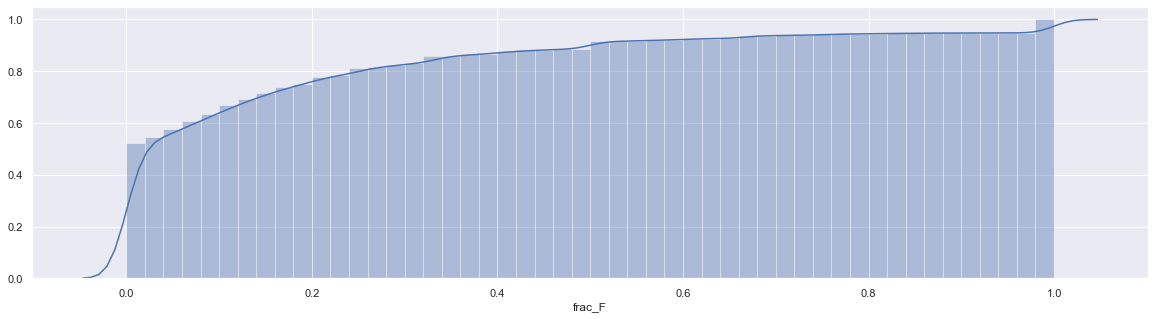

In [228]:
frac_F = genero_df['frac_F'].dropna()

sns.distplot(frac_F,
             hist_kws=dict(cumulative=True),
             kde_kws=dict(cumulative=True))

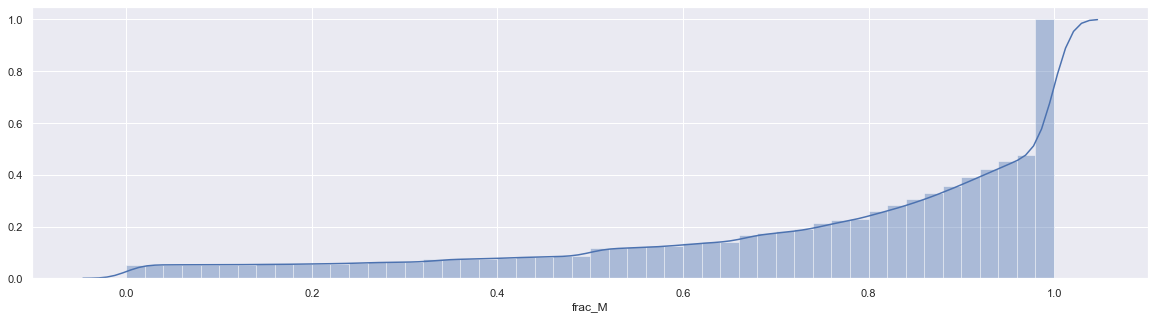

In [229]:
frac_F = genero_df['frac_M'].dropna()

sns.distplot(frac_F,
             hist_kws=dict(cumulative=True),
             kde_kws=dict(cumulative=True))

In [175]:
# antes de abril 2008 hay muy pocos datos
genero = genero.loc[genero['fecha'] > datetime(2008,4,1)]
genero.head()

,tema_id,M,F,fecha,mensajes,frac_M,frac_F
0,2204304,6,1,2019-03-15 12:51:56,7,0.857143,0.142857
1,64582,1,0,2008-08-30 00:11:00,1,1.000000,0.000000
2,2203704,3,4,2019-03-14 00:23:19,7,0.428571,0.571429
3,2205306,2,0,2019-03-18 15:33:35,2,1.000000,0.000000
4,359250,32,4,2010-04-14 11:51:09,36,0.888889,0.111111


In [178]:
promedio_por_dia = genero.set_index('fecha').groupby(pd.Grouper(freq='D')).mean()
promedio_por_dia = promedio_por_dia.dropna()
promedio_por_dia.head()

,tema_id,M,F,mensajes,frac_M,frac_F
fecha,,,,,,
2008-04-01,16816.400000,15.200000,3.800000,19.0,0.912821,0.087179
2008-04-02,16866.500000,1.500000,0.000000,1.5,1.000000,0.000000
2008-04-03,16922.400000,48.800000,8.400000,57.2,0.832264,0.167736
2008-04-04,17077.666667,7.666667,4.333333,12.0,0.809524,0.190476
2008-04-05,17152.000000,6.000000,1.000000,7.0,0.857143,0.142857


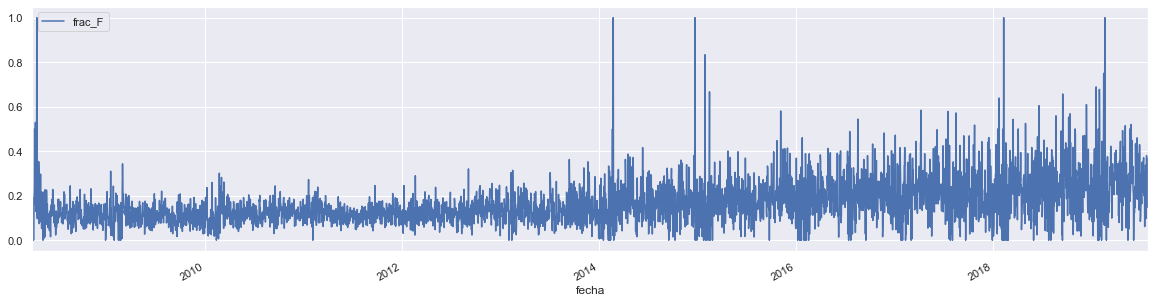

In [198]:
plt.rcParams['figure.figsize'] = [20, 5]
promedio_por_dia.reset_index().plot.line(x='fecha', y='frac_F')

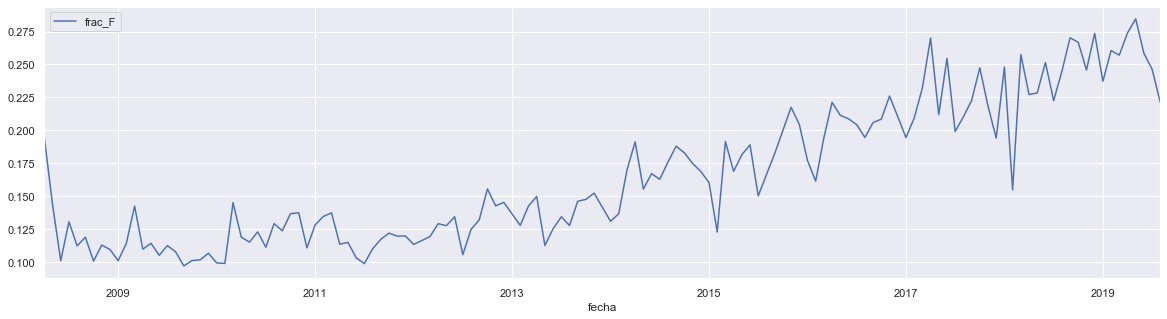

In [200]:
## promedio por mes

promedio_por_dia = genero.set_index('fecha').groupby(pd.Grouper(freq='M')).mean()
promedio_por_dia = promedio_por_dia.dropna()
plt.rcParams['figure.figsize'] = [20, 5]
promedio_por_dia.reset_index().plot.line(x='fecha', y='frac_F')

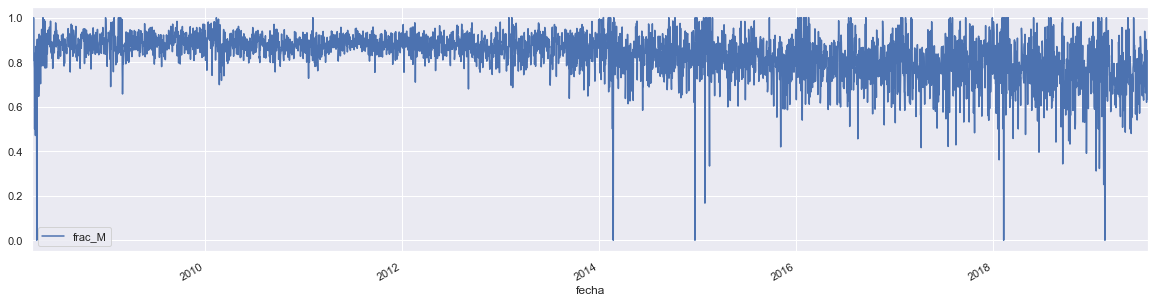

In [202]:
## promedio por dia

promedio_por_dia = genero.set_index('fecha').groupby(pd.Grouper(freq='D')).mean()
promedio_por_dia = promedio_por_dia.dropna()
plt.rcParams['figure.figsize'] = [20, 5]
promedio_por_dia.reset_index().plot.line(x='fecha', y='frac_M')

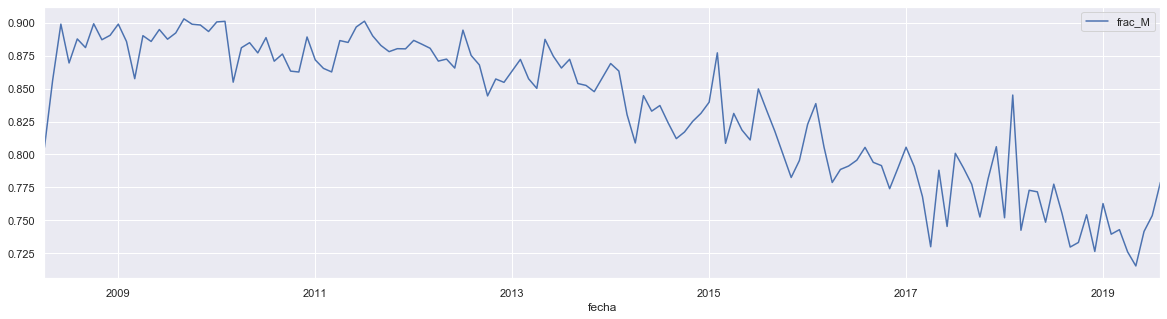

In [203]:
## promedio por mes

promedio_por_dia = genero.set_index('fecha').groupby(pd.Grouper(freq='M')).mean()
promedio_por_dia = promedio_por_dia.dropna()
plt.rcParams['figure.figsize'] = [20, 5]
promedio_por_dia.reset_index().plot.line(x='fecha', y='frac_M')

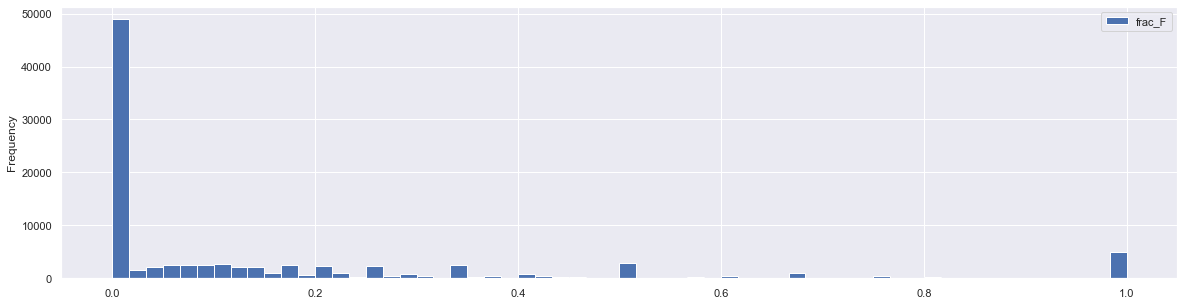

In [196]:
plt.rcParams['figure.figsize'] = [20, 5]
genero[['frac_F']].plot.hist(by='frac_F', bins=60)

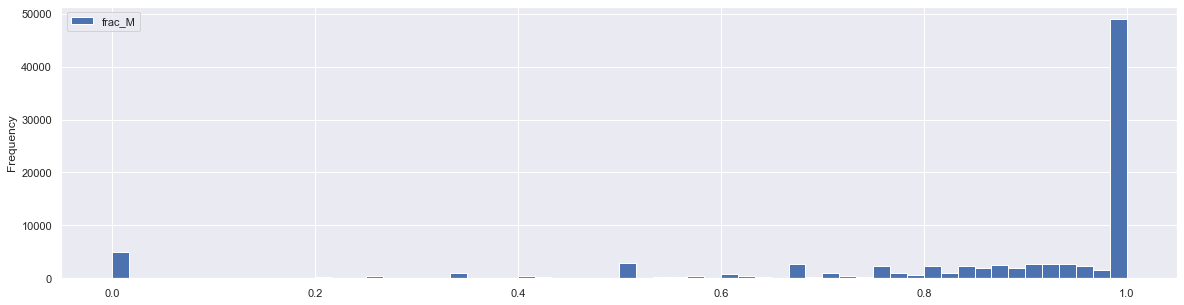

In [197]:
plt.rcParams['figure.figsize'] = [20, 5]
genero[['frac_M']].plot.hist(by='frac_M', bins=60)